In [33]:
import time
import numpy as np
import scipy as sp
import scipy.special
import matplotlib.pyplot as plt

In [34]:
# First, we set up the definitions for the power series of our activation functions.
def half_maclaurin(n):
    for i in range(n + 1):
        if i == 1:
            yield 0.5
        else:
            yield 0.0

def sine_maclaurin(n):
    fact = 1.0
    for i in range(n + 1):
        if i > 0:
            fact = fact / i
        
        if i % 2 == 0:
            yield 0.0
        else:
            yield (-1)**(i // 2) * fact

functions = [
    (np.sin, sine_maclaurin, "Sine"),
    (lambda x: 0.5 * x, half_maclaurin, "Half")
]

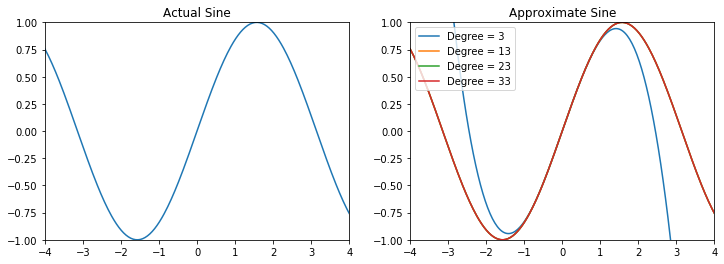

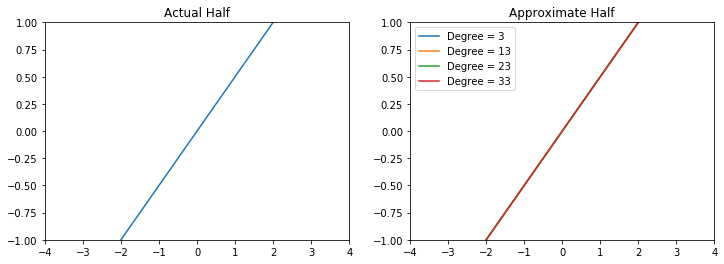

In [35]:
# Second, we check that the power series expansions are correct by simply plotting actual versus approximate.
degrees = [3, 13, 23, 33]

for fn, gfn, name in functions:
    x = np.linspace(-4.0, 4.0, 256)
    y = fn(x)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    axes[0].plot(x, y)
    axes[0].set_xlim(-4.0, 4.0)
    axes[0].set_ylim(-1.0, 1.0)
    axes[0].set_title(f"Actual {name}")

    for d in degrees:
        coeffs = list(gfn(d))
        z = np.zeros_like(x)

        for n, c in enumerate(coeffs):
            z = z + (c * np.power(x, n))

        axes[1].plot(x, z, label=f"Degree = {d}")
    axes[1].set_xlim(-4.0, 4.0)
    axes[1].set_ylim(-1.0, 1.0)
    axes[1].set_title(f"Approximate {name}")
    axes[1].legend()
    
    plt.show()

In [36]:
# Third, we check the errors in the scalar case.
# Note: s_n is n-th coefficient in power series of function.
#       a_n is n-th coefficient in power series of variable.
# The following solves for the new coefficients in a power series transformation.
def solve_icoeff(s, a, i):
    """Solve for the i-th coefficient in the new power series of $s(x)$.
    Arguments:
    s -- coefficients of power series of function.
    a -- coefficients of power series of variable.
    i -- the index of the coefficient to obtain.
    """
    
    def index_constraint(k_array, k):
        sum_k = 0
        for k_val in k_array:
            sum_k += k_val
            
        return k == sum_k
    
    def power_constraint(k_array, k):
        sum_k = 0
        for j, k_val in enumerate(k_array):
            sum_k += j * k_val
            
        return k == sum_k
    
    def candidate_ks(k_array, k):
        if len(k_array) == 1:
            k_array[0] = k
            yield k_array
        else:
            for j in range(0, k + 1):
                k_array[0] = j
                for solns in candidate_ks(k_array[1:], k - j):
                    yield k_array
    
    def multinomial(k_array):
        if len(k_array) == 1:
            return 1
        return sp.special.binom(sum(k_array), k_array[-1]) * multinomial(k_array[:-1])
    
    coeff = 0.0
    k_array = np.zeros(len(a), dtype=int)
    
    for k in range(len(s)):
        for k_soln in candidate_ks(k_array, k):
            # Check if constraints are satisfied.
            # Then, add the appropriate term.
            if (power_constraint(k_soln, i)):
                prod = 1.0
                for d in range(len(a)):
                    prod *= np.power(a[d], k_soln[d])
                coeff += s[k] * multinomial(k_soln) * prod
                    
    return coeff

In [45]:
x, dx = np.linspace(-4.0, 4.0, num=8192, retstep=True)

func_degrees = [1, 3, 5, 9, 11]
var_degrees = [5, 7, 9, 11]
depths = [1, 2, 3]

runtimes = []

for fn, gfn, name in functions:
    print(f"{'-'*8}{name}{'-'*8}")
    for func_d in func_degrees:
        # Create Maclaurin series coefficients.
        s = np.array(list(gfn(func_d)))
        
        for var_d in var_degrees:
            # Intialize approximation.
            y = x
            b = np.zeros(var_d + 1)
            b[1] = 1.0

            for depth in depths:
                # Calculate actual function approximation.
                y = fn(y)

                # Perform the transformation.
                c = np.zeros_like(b)
                start = time.time()
                for i in range(var_d + 1):
                    c[i] = solve_icoeff(s, b, i)
                end = time.time()
                b = c
                elapsed = end - start

                # Get the power series estimation.
                z = np.zeros_like(x)
                for i in range(var_d + 1):
                    z = z + (b[i] * np.power(x, i))

                # Find the error in the approximation.
                error = np.sqrt(dx * np.sum(np.power(y - z, 2.0)))

                print(f"N={func_d},\t D={var_d},\t Depth={depth}:\t Error={error:17.12f},\t Time={elapsed:.8f}")
            

--------Sine--------
N=1,	 D=5,	 Depth=1:	 Error=   6.225994027889,	 Time=0.00122833
N=1,	 D=5,	 Depth=2:	 Error=   6.252568935435,	 Time=0.00061584
N=1,	 D=5,	 Depth=3:	 Error=   6.271928629772,	 Time=0.00065088
N=1,	 D=7,	 Depth=1:	 Error=   6.225994027889,	 Time=0.00111628
N=1,	 D=7,	 Depth=2:	 Error=   6.252568935435,	 Time=0.00111723
N=1,	 D=7,	 Depth=3:	 Error=   6.271928629772,	 Time=0.00111508
N=1,	 D=9,	 Depth=1:	 Error=   6.225994027889,	 Time=0.00186896
N=1,	 D=9,	 Depth=2:	 Error=   6.252568935435,	 Time=0.00202465
N=1,	 D=9,	 Depth=3:	 Error=   6.271928629772,	 Time=0.00192904
N=1,	 D=11,	 Depth=1:	 Error=   6.225994027889,	 Time=0.00290060
N=1,	 D=11,	 Depth=2:	 Error=   6.252568935435,	 Time=0.00295186
N=1,	 D=11,	 Depth=3:	 Error=   6.271928629772,	 Time=0.00288677
N=3,	 D=5,	 Depth=1:	 Error=   5.339799899957,	 Time=0.00427461
N=3,	 D=5,	 Depth=2:	 Error=  56.406293040447,	 Time=0.00424170
N=3,	 D=5,	 Depth=3:	 Error= 190.912504714616,	 Time=0.00473046
N=3,	 D=7,	 Dept

--------Sine--------


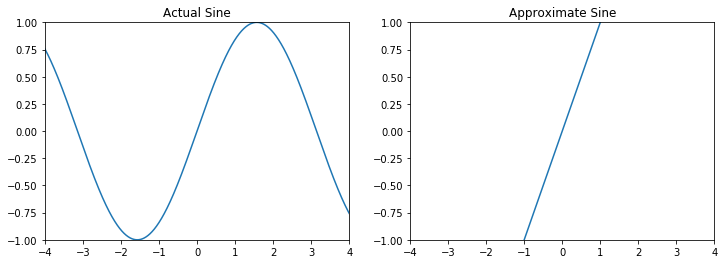

N=1,	 D=5,	 Depth=1:	 Error=   6.225994027889,	 Time=0.00133824


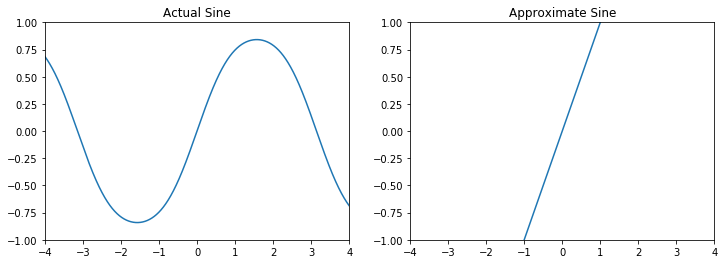

N=1,	 D=5,	 Depth=2:	 Error=   6.252568935435,	 Time=0.00121093


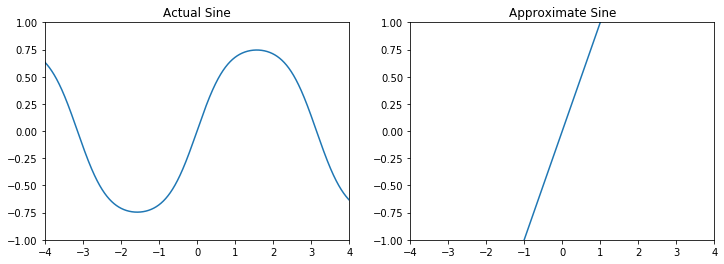

N=1,	 D=5,	 Depth=3:	 Error=   6.271928629772,	 Time=0.00134039


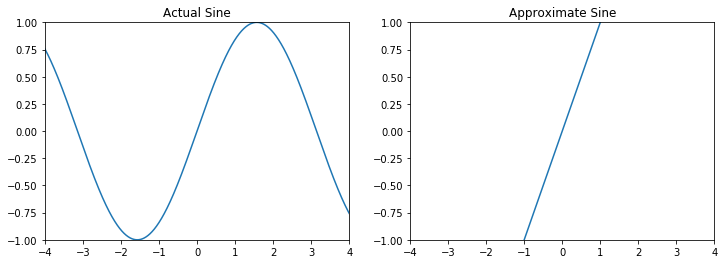

N=1,	 D=7,	 Depth=1:	 Error=   6.225994027889,	 Time=0.00256062


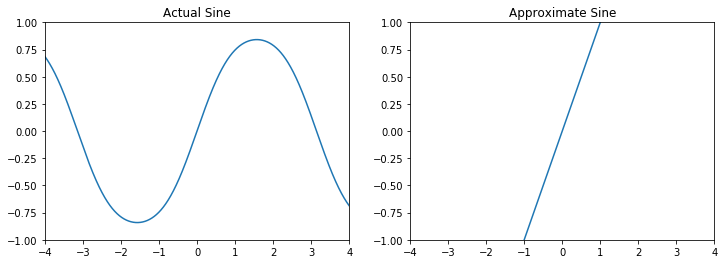

N=1,	 D=7,	 Depth=2:	 Error=   6.252568935435,	 Time=0.00113487


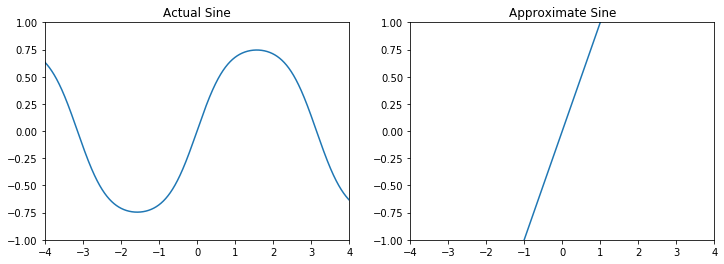

N=1,	 D=7,	 Depth=3:	 Error=   6.271928629772,	 Time=0.00115252


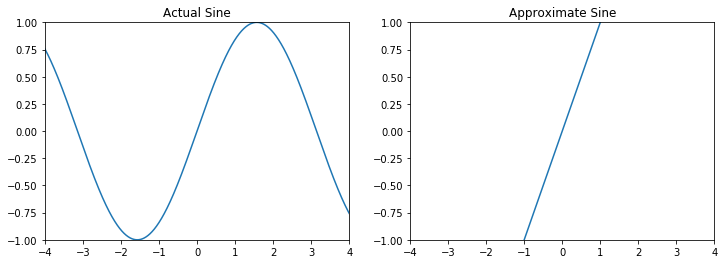

N=1,	 D=9,	 Depth=1:	 Error=   6.225994027889,	 Time=0.00281835


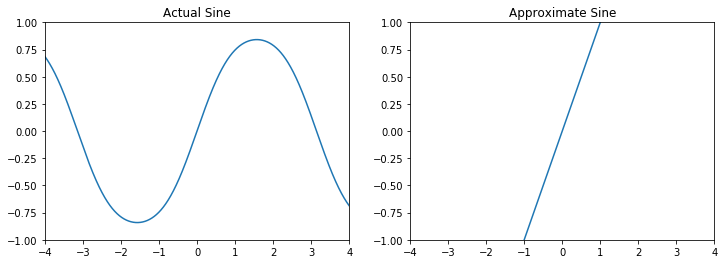

N=1,	 D=9,	 Depth=2:	 Error=   6.252568935435,	 Time=0.00195742


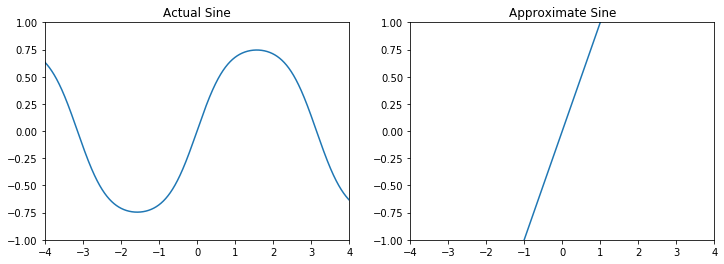

N=1,	 D=9,	 Depth=3:	 Error=   6.271928629772,	 Time=0.00191021


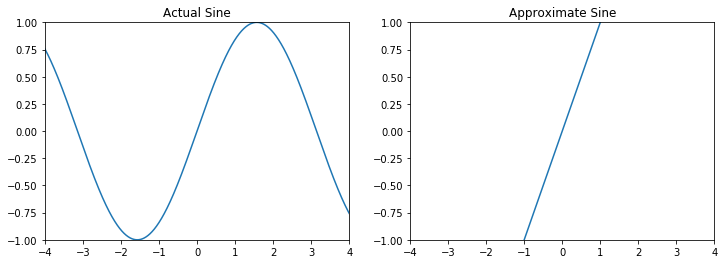

N=1,	 D=11,	 Depth=1:	 Error=   6.225994027889,	 Time=0.00301170


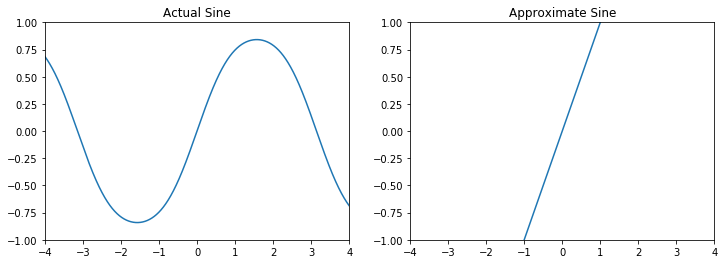

N=1,	 D=11,	 Depth=2:	 Error=   6.252568935435,	 Time=0.00302601


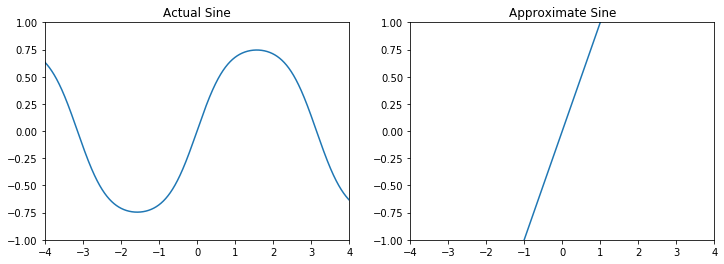

N=1,	 D=11,	 Depth=3:	 Error=   6.271928629772,	 Time=0.00296617


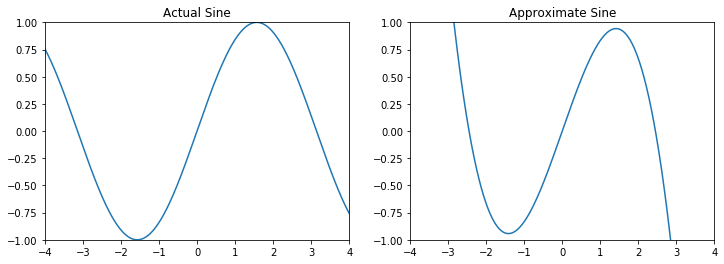

N=3,	 D=5,	 Depth=1:	 Error=   5.339799899957,	 Time=0.00456405


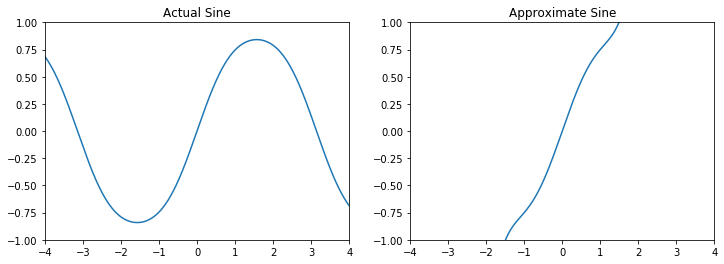

N=3,	 D=5,	 Depth=2:	 Error=  56.406293040447,	 Time=0.00483322


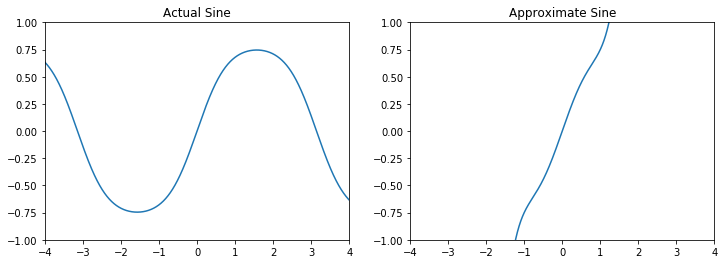

N=3,	 D=5,	 Depth=3:	 Error= 190.912504714616,	 Time=0.00433183


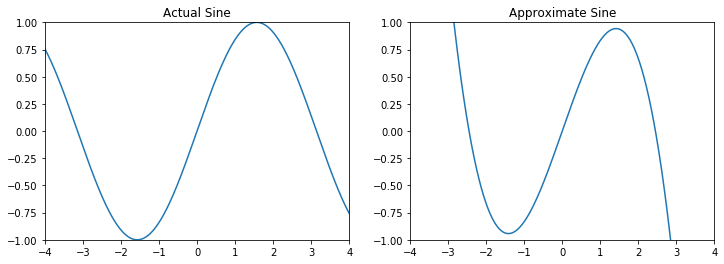

N=3,	 D=7,	 Depth=1:	 Error=   5.339799899957,	 Time=0.01280236


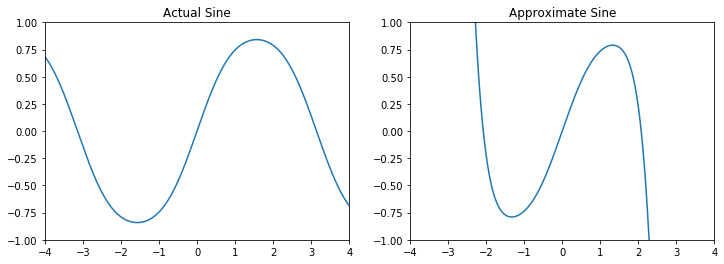

N=3,	 D=7,	 Depth=2:	 Error= 110.442899916507,	 Time=0.01286149


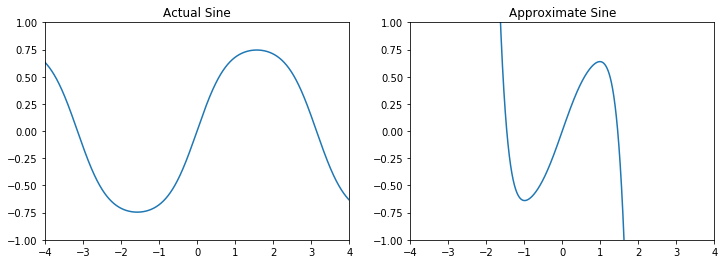

N=3,	 D=7,	 Depth=3:	 Error=1141.625147660795,	 Time=0.01225710


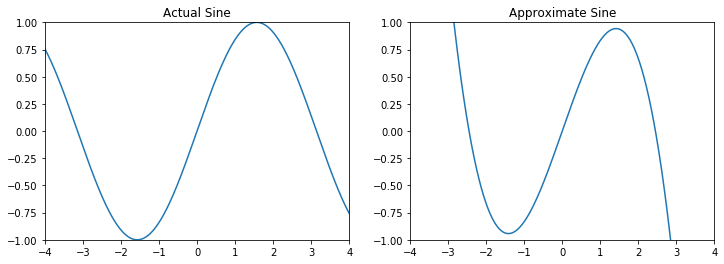

N=3,	 D=9,	 Depth=1:	 Error=   5.339799899957,	 Time=0.03178406


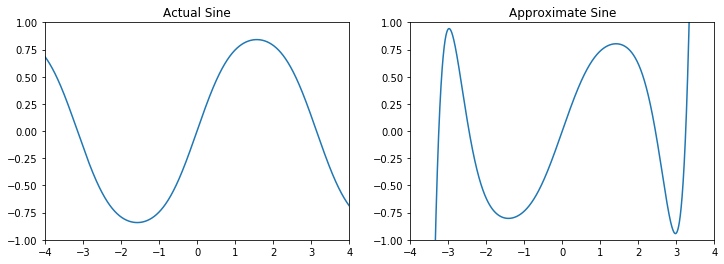

N=3,	 D=9,	 Depth=2:	 Error=  22.296404867303,	 Time=0.02912164


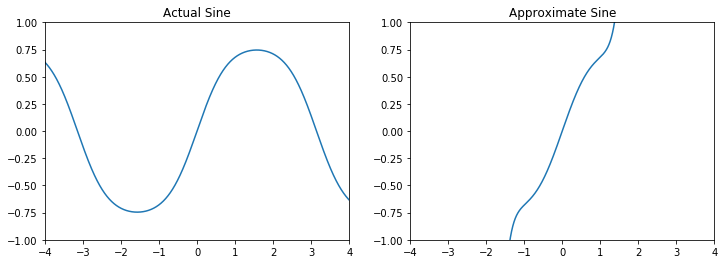

N=3,	 D=9,	 Depth=3:	 Error=5960.544062731309,	 Time=0.02854013


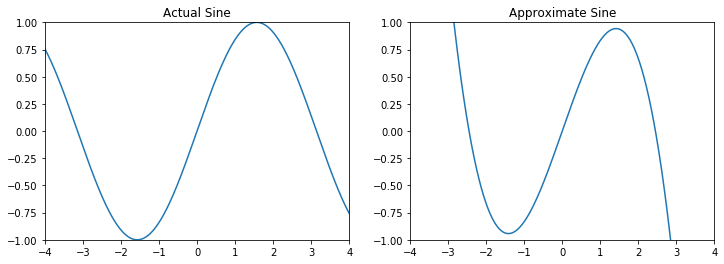

N=3,	 D=11,	 Depth=1:	 Error=   5.339799899957,	 Time=0.06221199


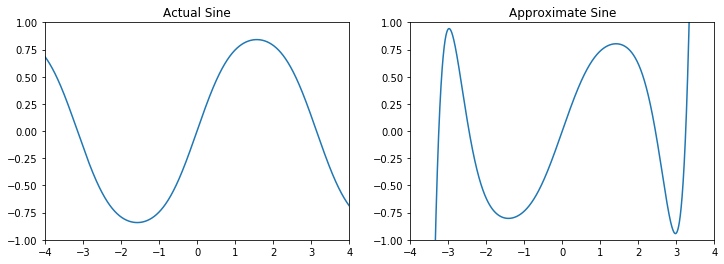

N=3,	 D=11,	 Depth=2:	 Error=  22.296404867303,	 Time=0.06324720


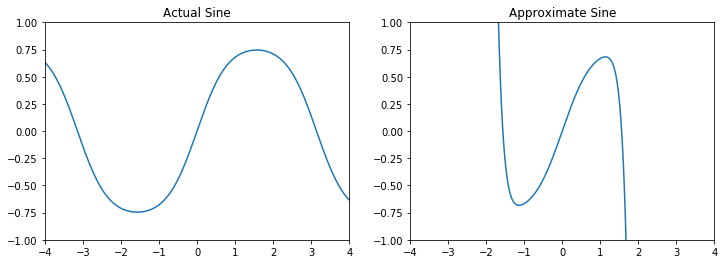

N=3,	 D=11,	 Depth=3:	 Error=26554.506107362584,	 Time=0.06228447


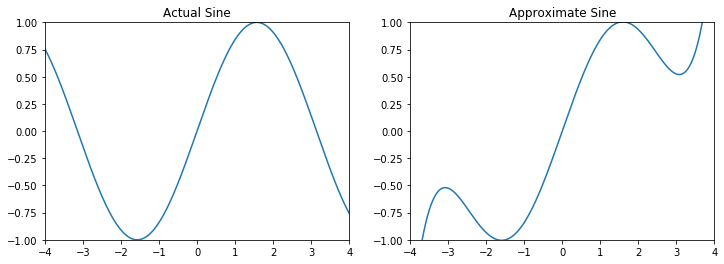

N=5,	 D=5,	 Depth=1:	 Error=   1.966073010690,	 Time=0.01739907


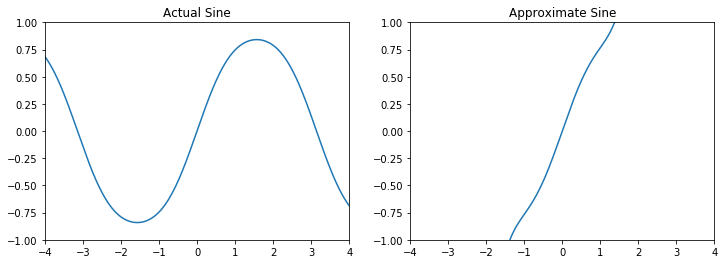

N=5,	 D=5,	 Depth=2:	 Error=  70.957489884435,	 Time=0.01745653


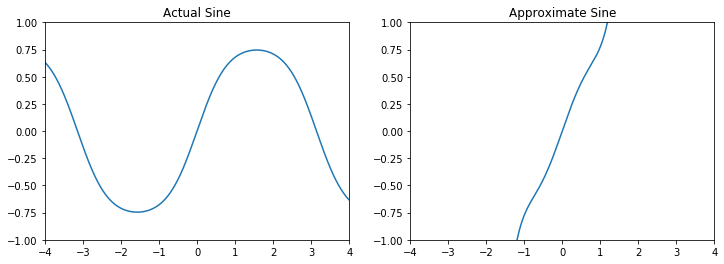

N=5,	 D=5,	 Depth=3:	 Error= 212.751817087995,	 Time=0.01729012


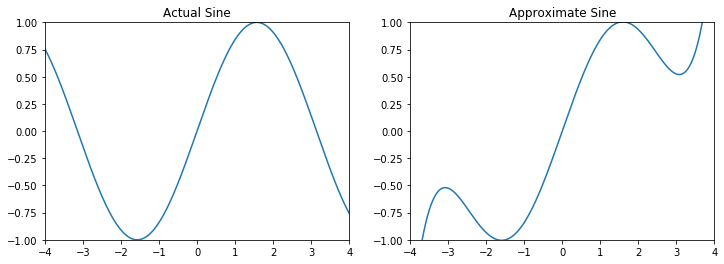

N=5,	 D=7,	 Depth=1:	 Error=   1.966073010690,	 Time=0.07239056


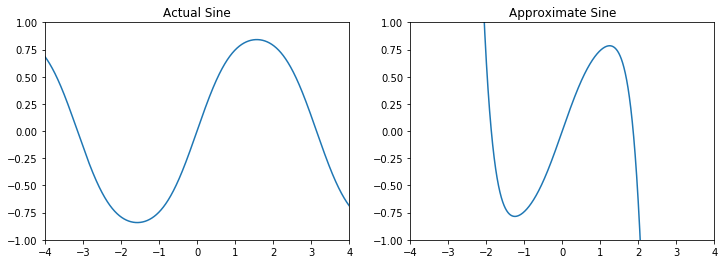

N=5,	 D=7,	 Depth=2:	 Error= 229.101337180224,	 Time=0.07240009


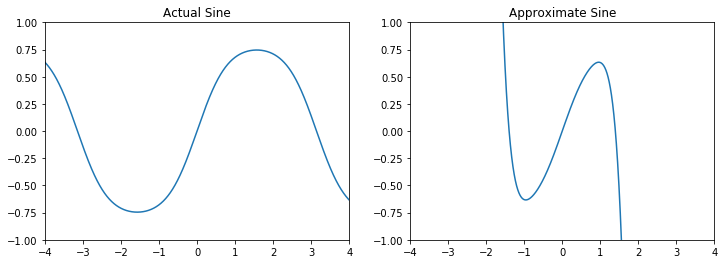

N=5,	 D=7,	 Depth=3:	 Error=1519.235606603592,	 Time=0.07180715


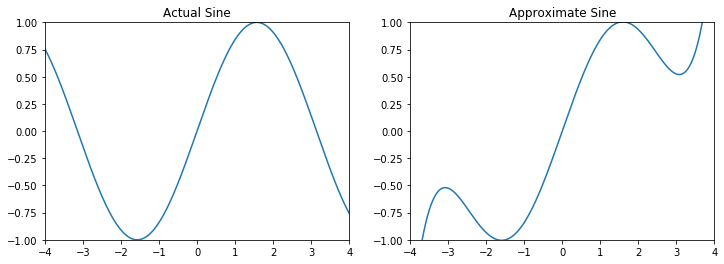

N=5,	 D=9,	 Depth=1:	 Error=   1.966073010690,	 Time=0.23641348


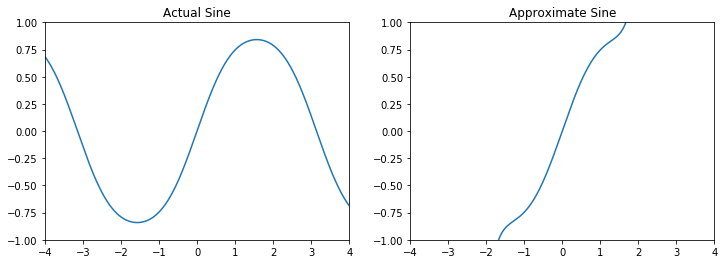

N=5,	 D=9,	 Depth=2:	 Error= 593.238356727496,	 Time=0.23260951


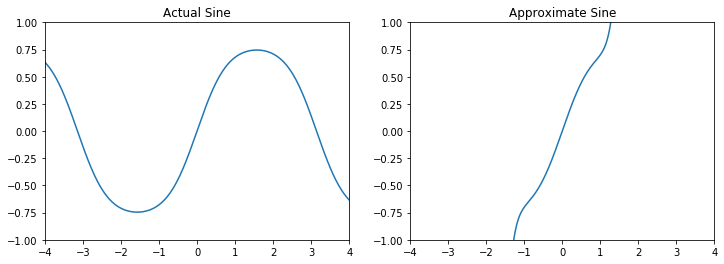

N=5,	 D=9,	 Depth=3:	 Error=10453.739473055215,	 Time=0.23314023


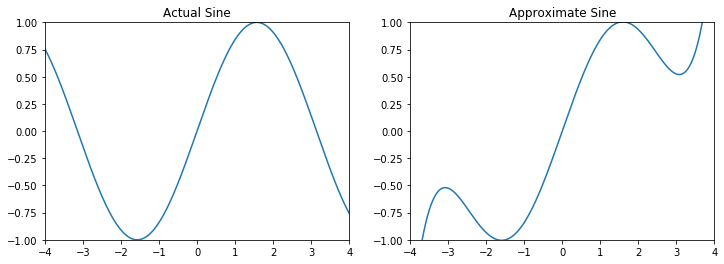

N=5,	 D=11,	 Depth=1:	 Error=   1.966073010690,	 Time=0.64082670


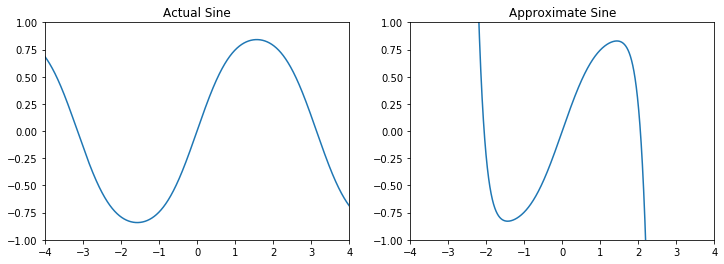

N=5,	 D=11,	 Depth=2:	 Error=1310.349096662902,	 Time=0.63608050


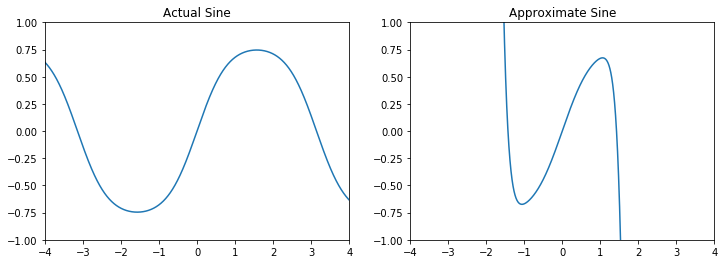

N=5,	 D=11,	 Depth=3:	 Error=68238.894160013268,	 Time=0.68120480


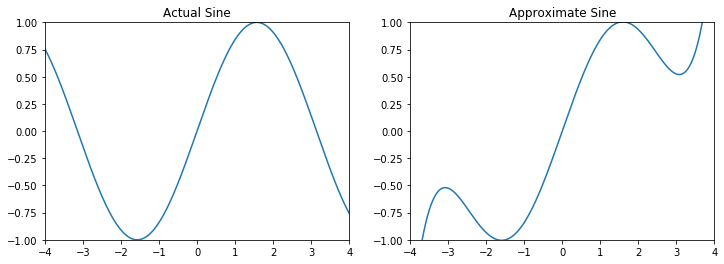

N=9,	 D=5,	 Depth=1:	 Error=   1.966073010690,	 Time=0.15291953


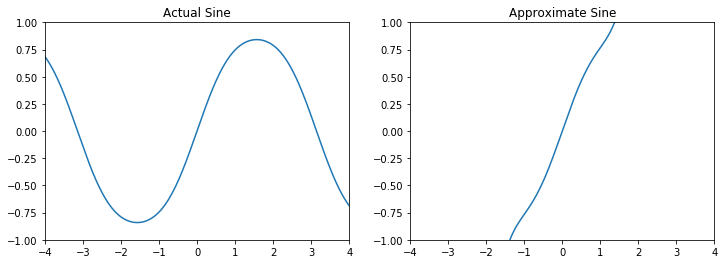

N=9,	 D=5,	 Depth=2:	 Error=  70.957489884435,	 Time=0.15165424


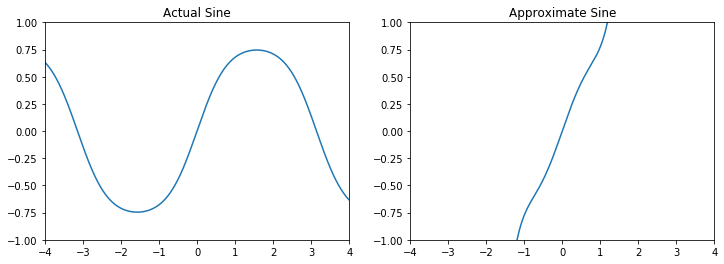

N=9,	 D=5,	 Depth=3:	 Error= 212.751817087995,	 Time=0.14753079


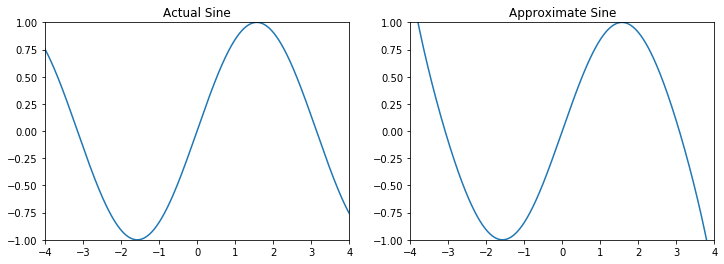

N=9,	 D=7,	 Depth=1:	 Error=   0.412954340770,	 Time=1.12865734


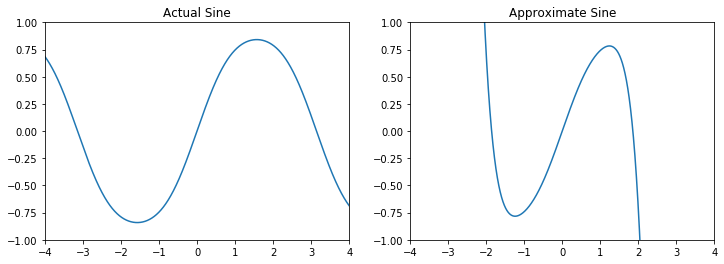

N=9,	 D=7,	 Depth=2:	 Error= 233.850631401400,	 Time=1.11938572


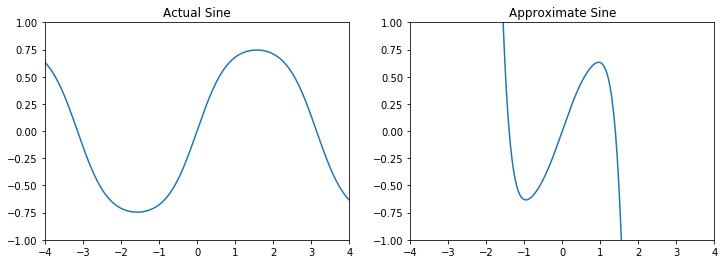

N=9,	 D=7,	 Depth=3:	 Error=1526.363060025546,	 Time=1.13097239


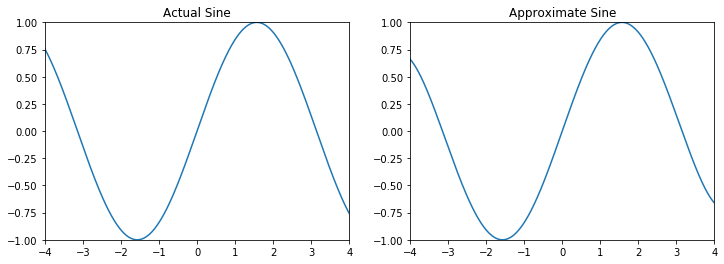

N=9,	 D=9,	 Depth=1:	 Error=   0.056593566302,	 Time=6.17505431


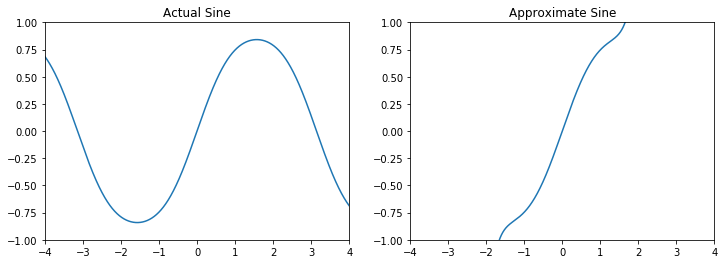

N=9,	 D=9,	 Depth=2:	 Error= 645.765519252626,	 Time=6.13828635


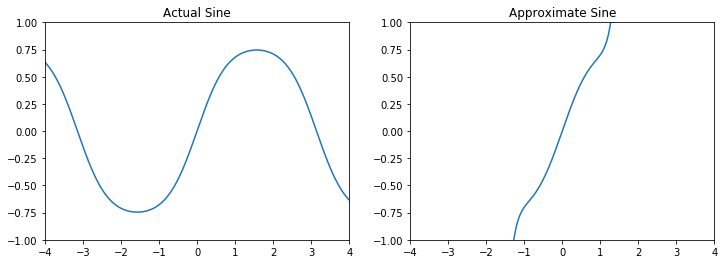

N=9,	 D=9,	 Depth=3:	 Error=10617.010520077078,	 Time=6.15395594


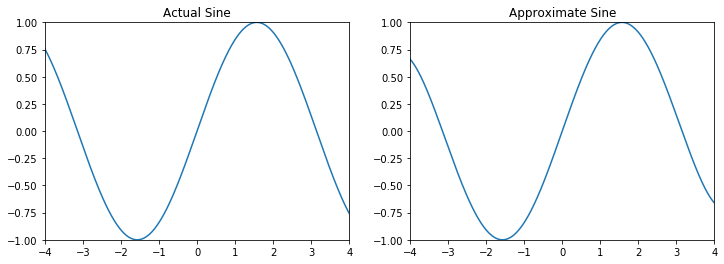

N=9,	 D=11,	 Depth=1:	 Error=   0.056593566302,	 Time=26.81013727


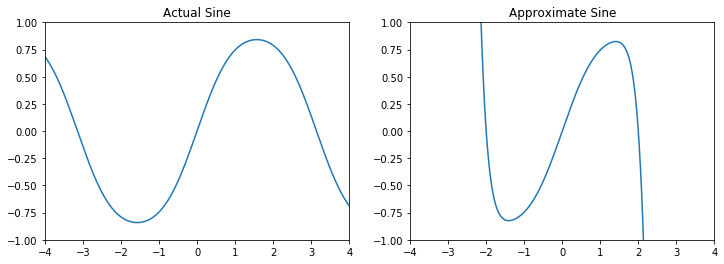

N=9,	 D=11,	 Depth=2:	 Error=1689.407486409085,	 Time=27.70196319


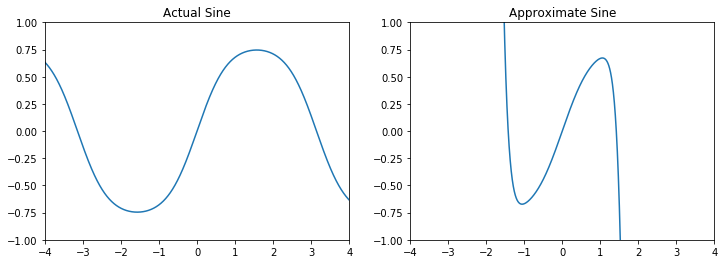

N=9,	 D=11,	 Depth=3:	 Error=70804.071640735434,	 Time=27.23978496


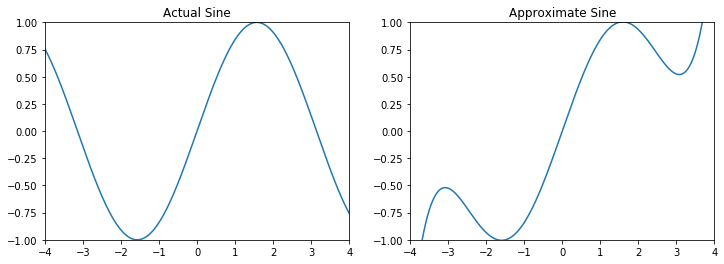

N=11,	 D=5,	 Depth=1:	 Error=   1.966073010690,	 Time=0.35243177


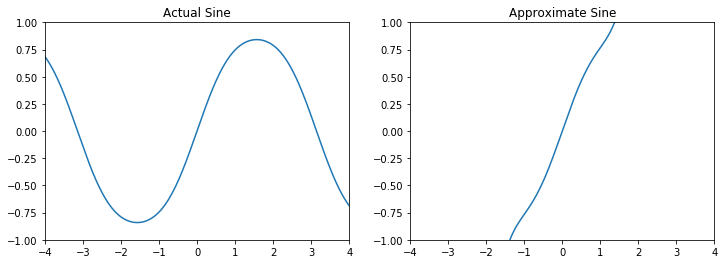

N=11,	 D=5,	 Depth=2:	 Error=  70.957489884435,	 Time=0.35193014


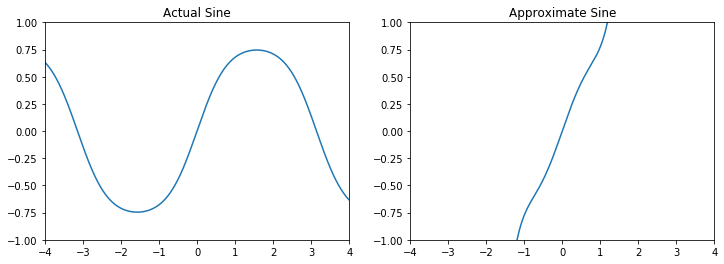

N=11,	 D=5,	 Depth=3:	 Error= 212.751817087995,	 Time=0.36130738


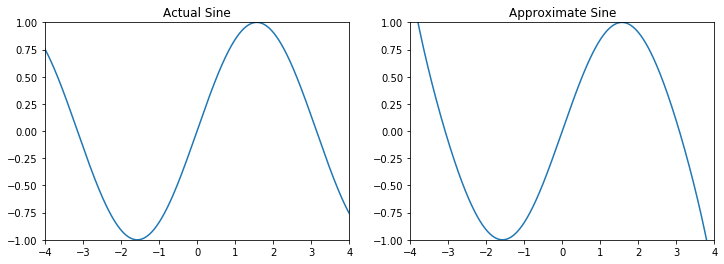

N=11,	 D=7,	 Depth=1:	 Error=   0.412954340770,	 Time=3.43395352


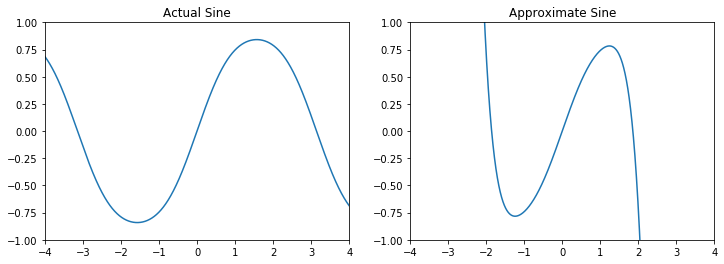

N=11,	 D=7,	 Depth=2:	 Error= 233.850631401400,	 Time=3.48473740


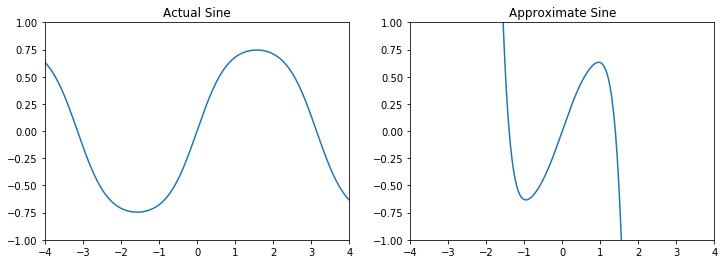

N=11,	 D=7,	 Depth=3:	 Error=1526.363060025546,	 Time=3.43198419


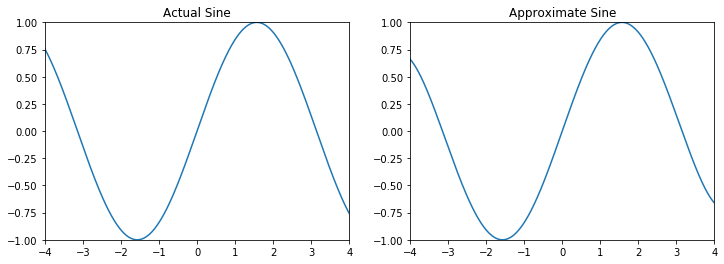

N=11,	 D=9,	 Depth=1:	 Error=   0.056593566302,	 Time=22.59335470


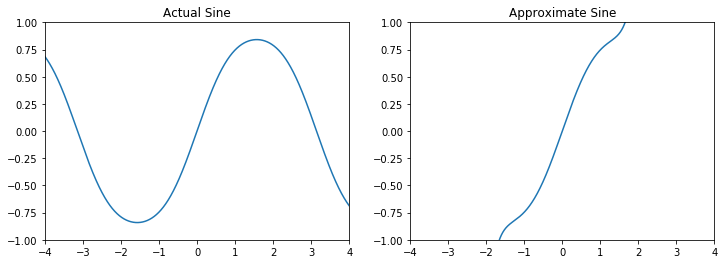

N=11,	 D=9,	 Depth=2:	 Error= 645.765519252626,	 Time=23.02168107


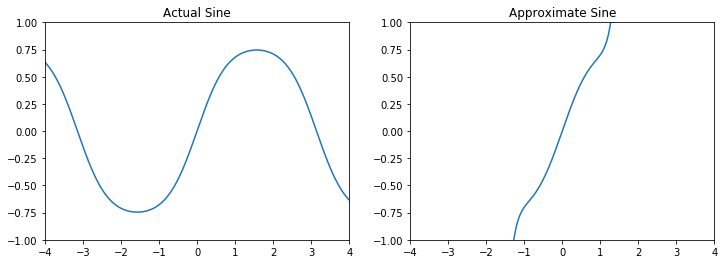

N=11,	 D=9,	 Depth=3:	 Error=10617.010520077078,	 Time=22.98580503


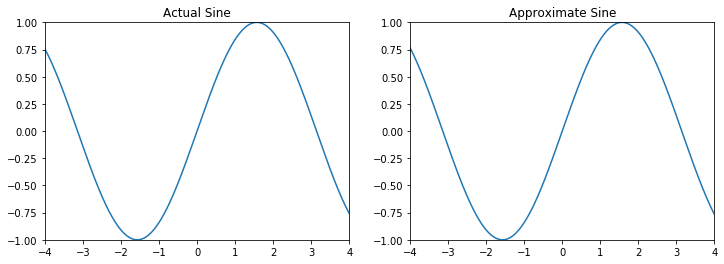

N=11,	 D=11,	 Depth=1:	 Error=   0.005481067673,	 Time=118.77799106


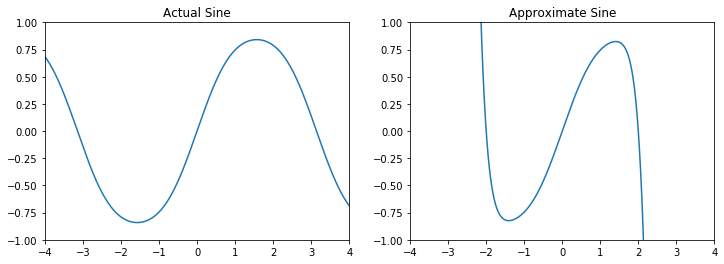

N=11,	 D=11,	 Depth=2:	 Error=1689.531562288227,	 Time=121.08463526


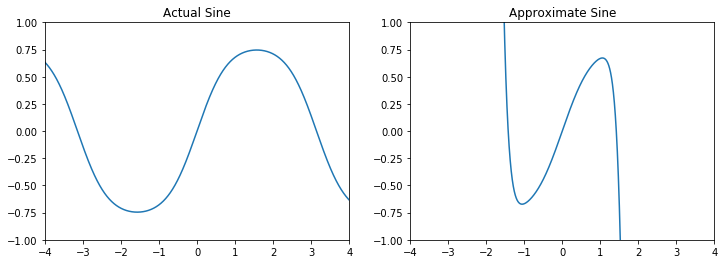

N=11,	 D=11,	 Depth=3:	 Error=70804.257799620187,	 Time=119.81661534
--------Half--------


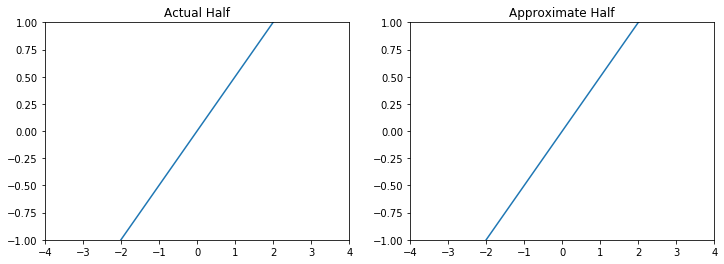

N=1,	 D=5,	 Depth=1:	 Error=   0.000000000000,	 Time=0.00060678


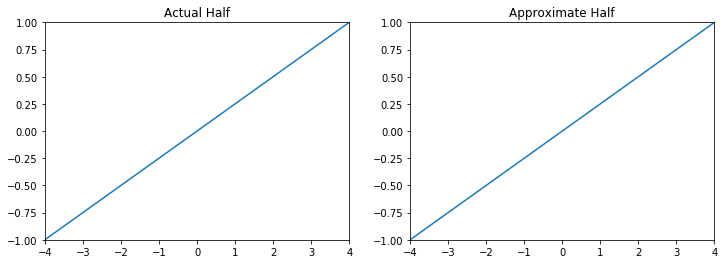

N=1,	 D=5,	 Depth=2:	 Error=   0.000000000000,	 Time=0.00062633


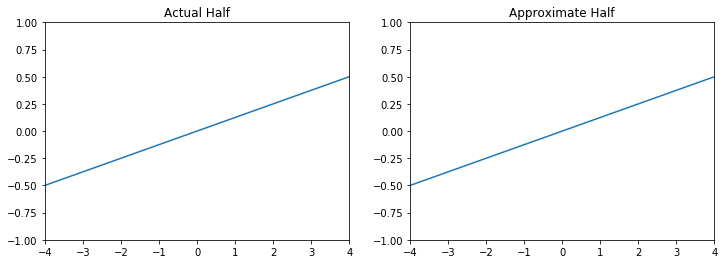

N=1,	 D=5,	 Depth=3:	 Error=   0.000000000000,	 Time=0.00060105


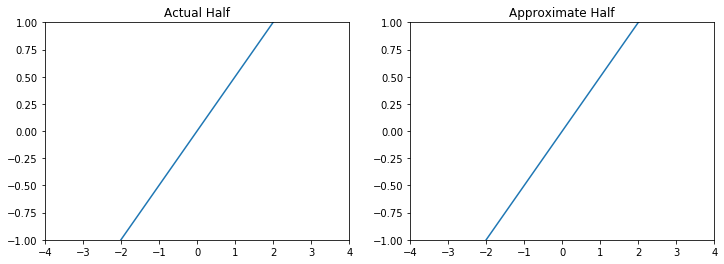

N=1,	 D=7,	 Depth=1:	 Error=   0.000000000000,	 Time=0.00110531


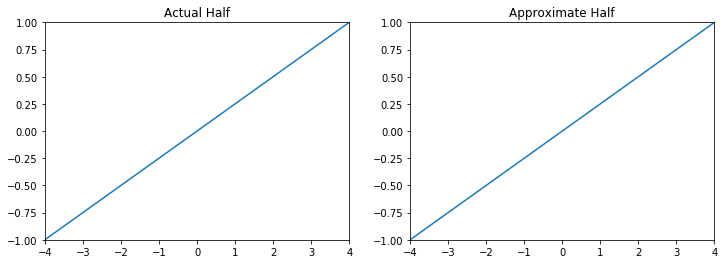

N=1,	 D=7,	 Depth=2:	 Error=   0.000000000000,	 Time=0.00113940


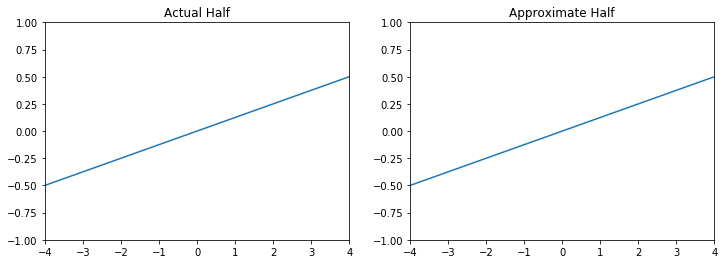

N=1,	 D=7,	 Depth=3:	 Error=   0.000000000000,	 Time=0.00115395


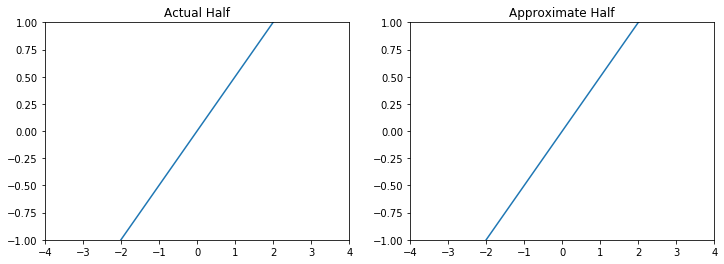

N=1,	 D=9,	 Depth=1:	 Error=   0.000000000000,	 Time=0.00188351


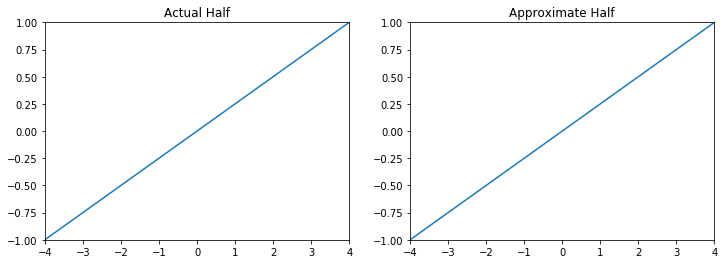

N=1,	 D=9,	 Depth=2:	 Error=   0.000000000000,	 Time=0.00189948


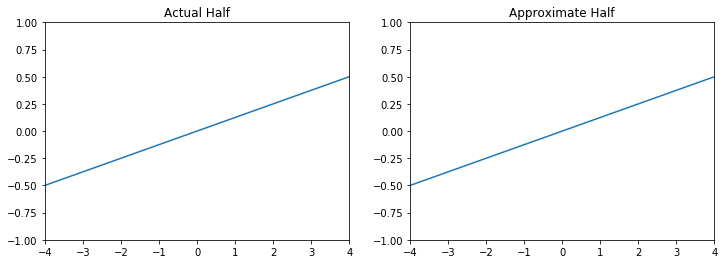

N=1,	 D=9,	 Depth=3:	 Error=   0.000000000000,	 Time=0.00190401


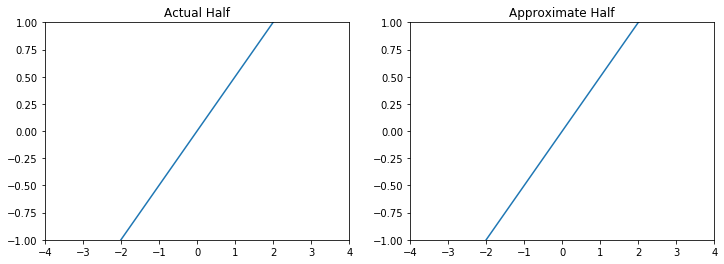

N=1,	 D=11,	 Depth=1:	 Error=   0.000000000000,	 Time=0.00290895


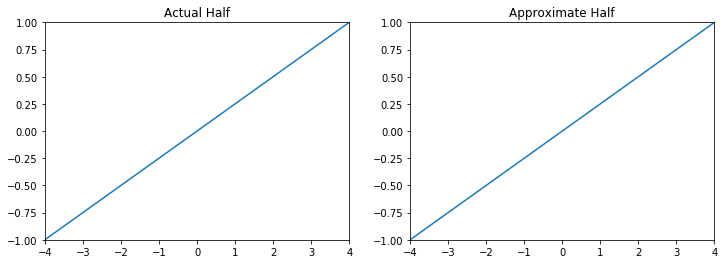

N=1,	 D=11,	 Depth=2:	 Error=   0.000000000000,	 Time=0.00300217


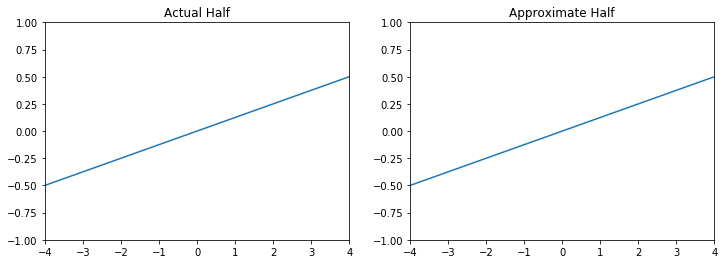

N=1,	 D=11,	 Depth=3:	 Error=   0.000000000000,	 Time=0.00301027


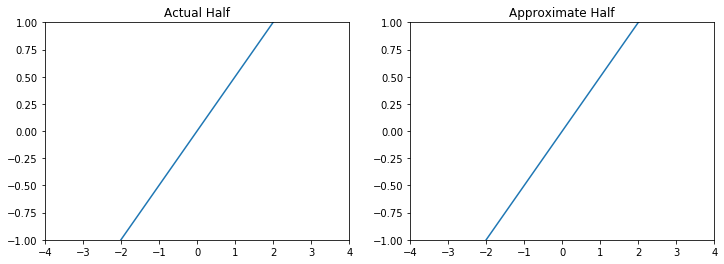

N=3,	 D=5,	 Depth=1:	 Error=   0.000000000000,	 Time=0.00471711


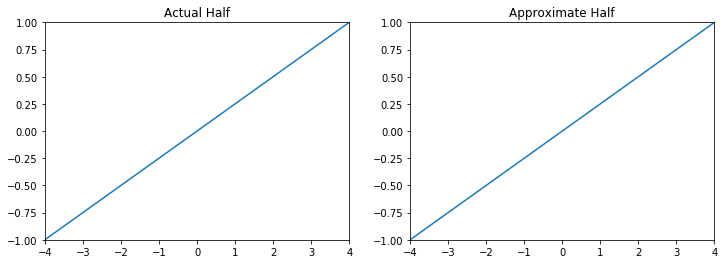

N=3,	 D=5,	 Depth=2:	 Error=   0.000000000000,	 Time=0.00436330


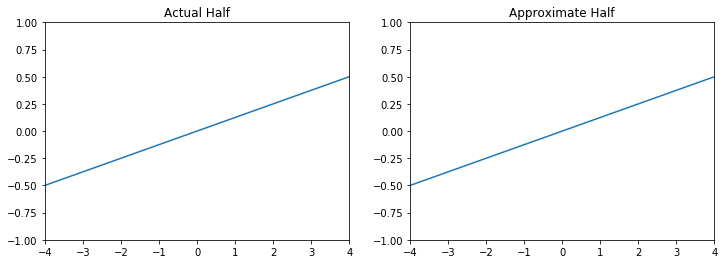

N=3,	 D=5,	 Depth=3:	 Error=   0.000000000000,	 Time=0.00473332


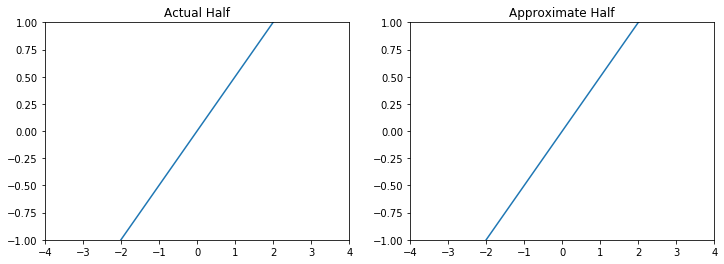

N=3,	 D=7,	 Depth=1:	 Error=   0.000000000000,	 Time=0.01326323


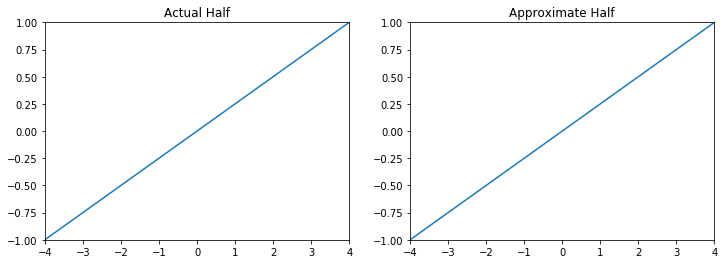

N=3,	 D=7,	 Depth=2:	 Error=   0.000000000000,	 Time=0.01282525


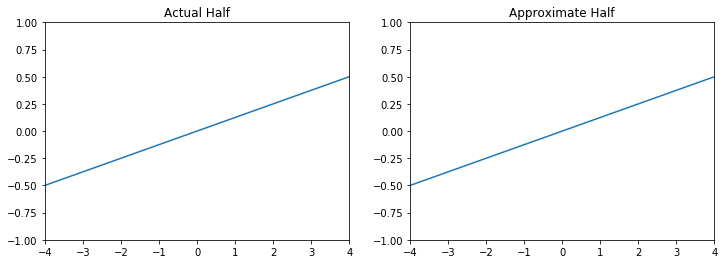

N=3,	 D=7,	 Depth=3:	 Error=   0.000000000000,	 Time=0.01257396


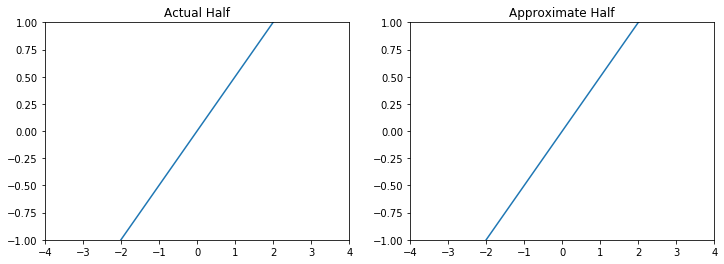

N=3,	 D=9,	 Depth=1:	 Error=   0.000000000000,	 Time=0.02923203


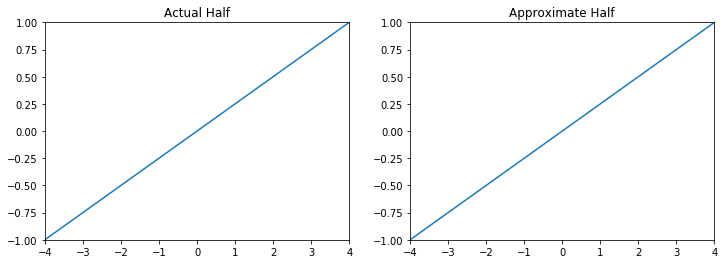

N=3,	 D=9,	 Depth=2:	 Error=   0.000000000000,	 Time=0.03006673


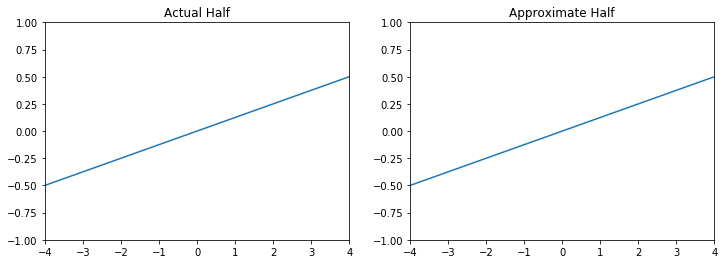

N=3,	 D=9,	 Depth=3:	 Error=   0.000000000000,	 Time=0.02822638


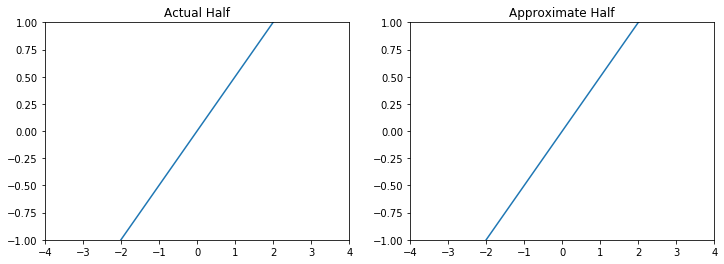

N=3,	 D=11,	 Depth=1:	 Error=   0.000000000000,	 Time=0.06177926


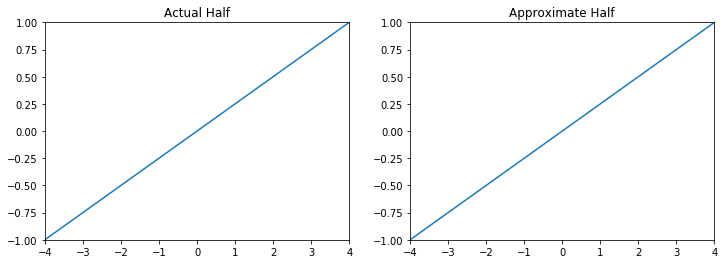

N=3,	 D=11,	 Depth=2:	 Error=   0.000000000000,	 Time=0.06205678


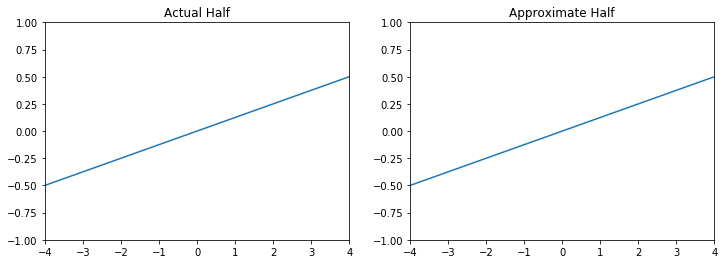

N=3,	 D=11,	 Depth=3:	 Error=   0.000000000000,	 Time=0.06197262


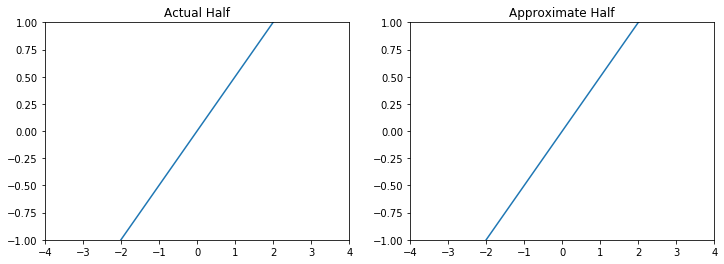

N=5,	 D=5,	 Depth=1:	 Error=   0.000000000000,	 Time=0.01810884


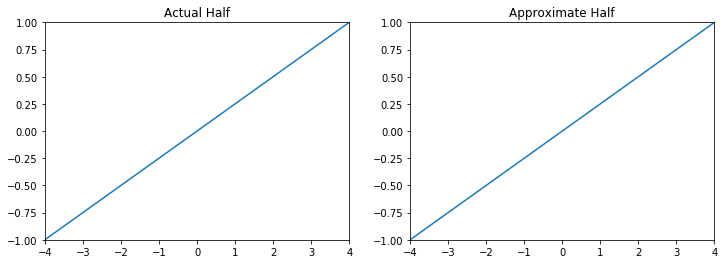

N=5,	 D=5,	 Depth=2:	 Error=   0.000000000000,	 Time=0.01750684


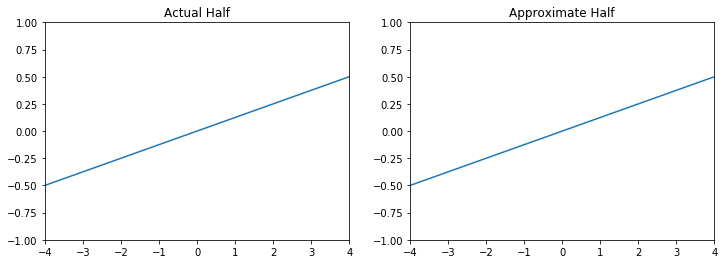

N=5,	 D=5,	 Depth=3:	 Error=   0.000000000000,	 Time=0.01805162


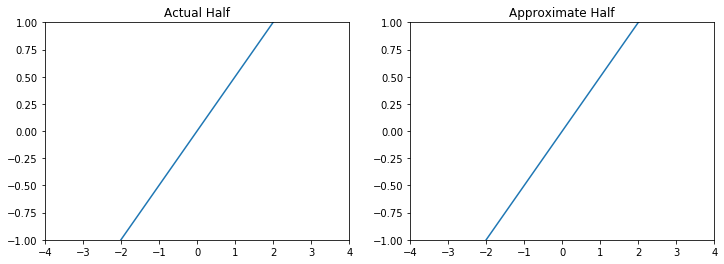

N=5,	 D=7,	 Depth=1:	 Error=   0.000000000000,	 Time=0.07287431


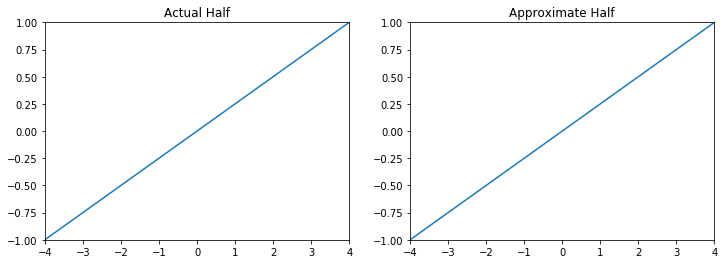

N=5,	 D=7,	 Depth=2:	 Error=   0.000000000000,	 Time=0.07106137


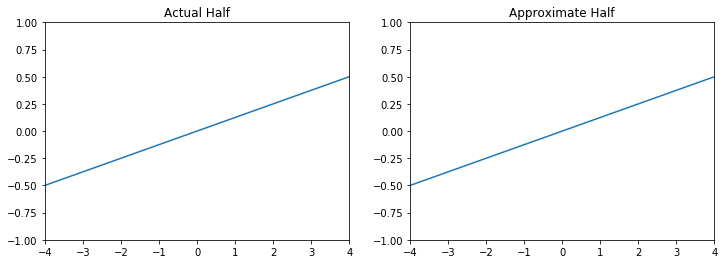

N=5,	 D=7,	 Depth=3:	 Error=   0.000000000000,	 Time=0.07220697


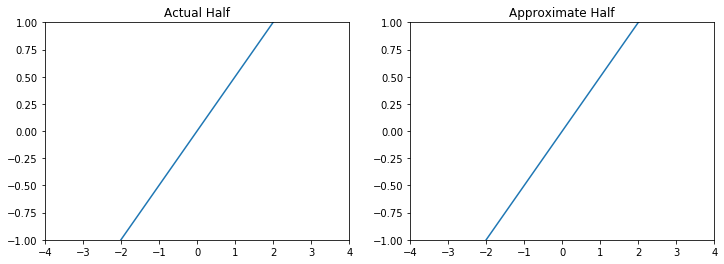

N=5,	 D=9,	 Depth=1:	 Error=   0.000000000000,	 Time=0.23022699


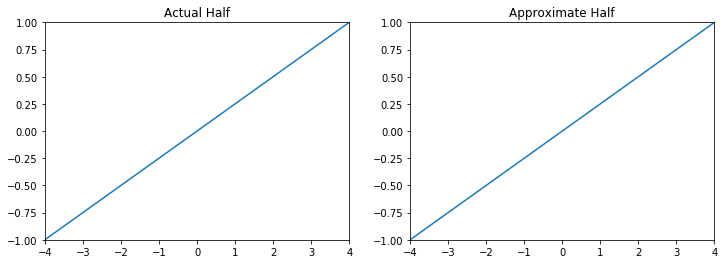

N=5,	 D=9,	 Depth=2:	 Error=   0.000000000000,	 Time=0.22837877


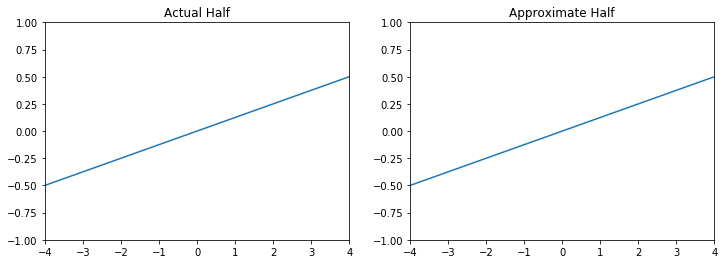

N=5,	 D=9,	 Depth=3:	 Error=   0.000000000000,	 Time=0.23730469


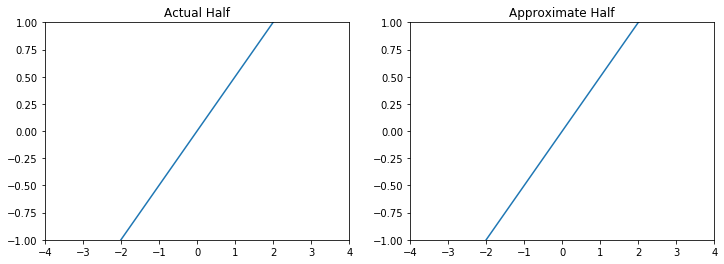

N=5,	 D=11,	 Depth=1:	 Error=   0.000000000000,	 Time=0.65840435


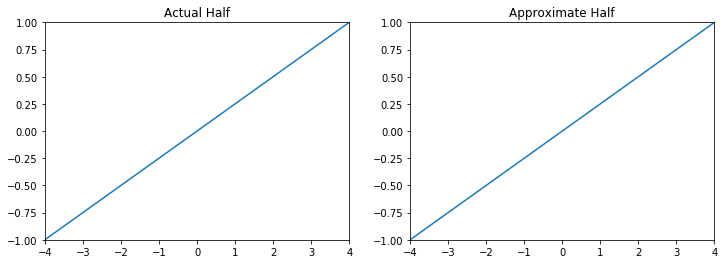

N=5,	 D=11,	 Depth=2:	 Error=   0.000000000000,	 Time=0.65353489


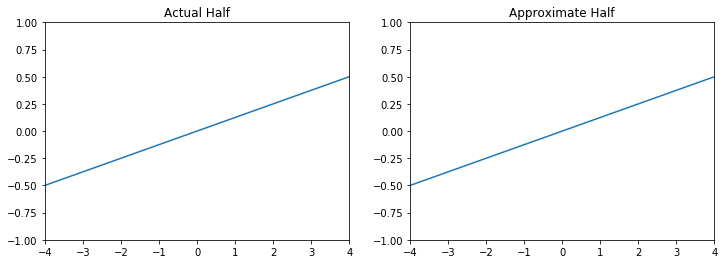

N=5,	 D=11,	 Depth=3:	 Error=   0.000000000000,	 Time=0.65877318


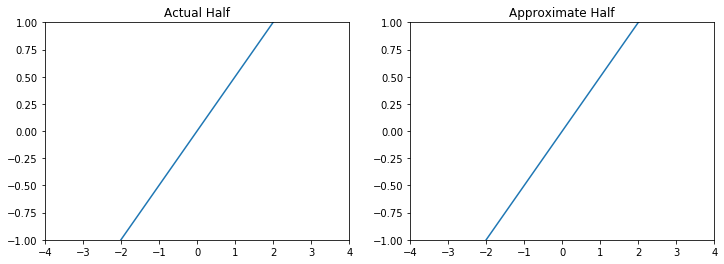

N=9,	 D=5,	 Depth=1:	 Error=   0.000000000000,	 Time=0.15174747


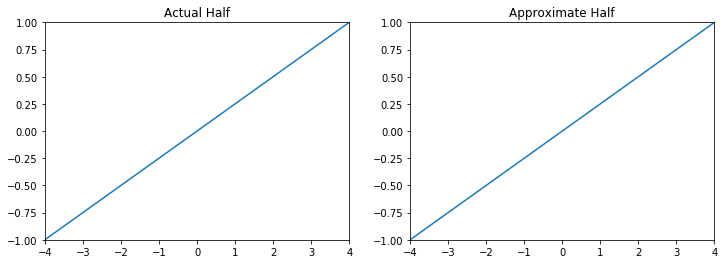

N=9,	 D=5,	 Depth=2:	 Error=   0.000000000000,	 Time=0.15003896


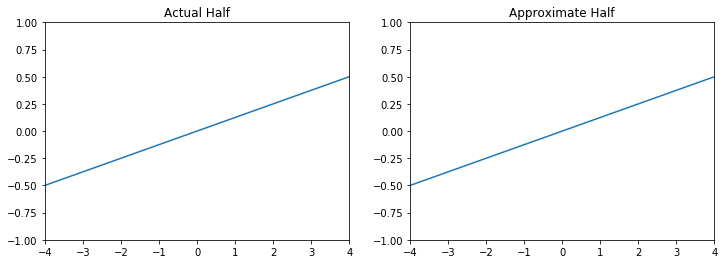

N=9,	 D=5,	 Depth=3:	 Error=   0.000000000000,	 Time=0.15186191


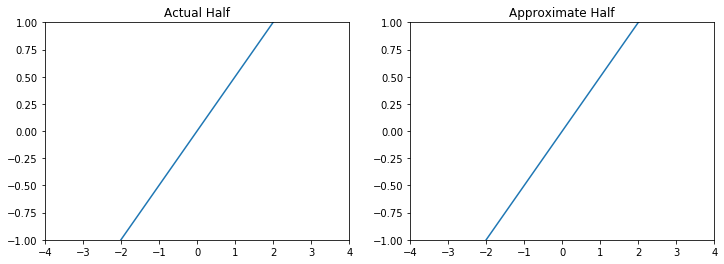

N=9,	 D=7,	 Depth=1:	 Error=   0.000000000000,	 Time=1.11480284


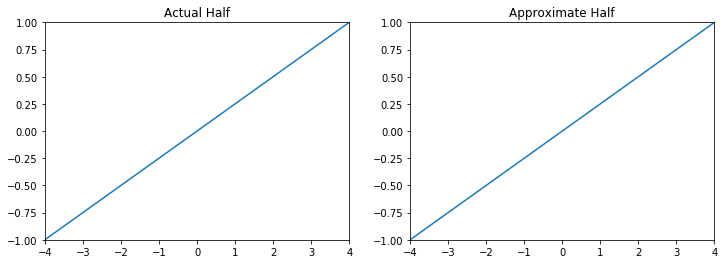

N=9,	 D=7,	 Depth=2:	 Error=   0.000000000000,	 Time=1.13608623


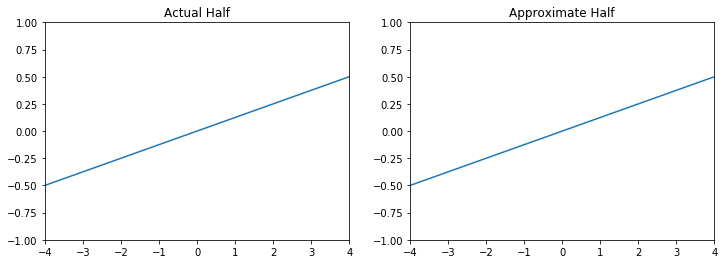

N=9,	 D=7,	 Depth=3:	 Error=   0.000000000000,	 Time=1.13129330


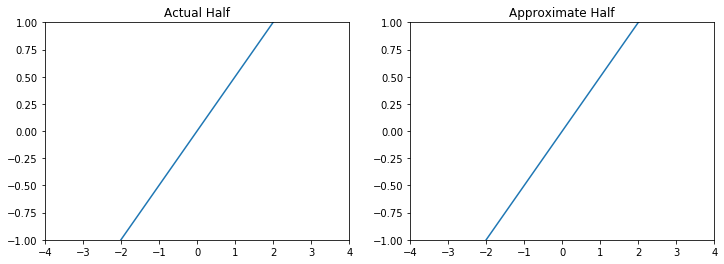

N=9,	 D=9,	 Depth=1:	 Error=   0.000000000000,	 Time=5.98313522


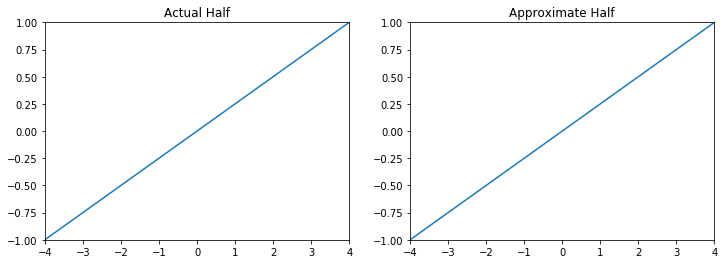

N=9,	 D=9,	 Depth=2:	 Error=   0.000000000000,	 Time=6.25997615


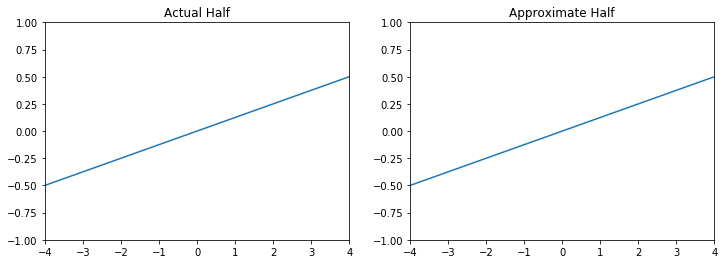

N=9,	 D=9,	 Depth=3:	 Error=   0.000000000000,	 Time=6.14648032


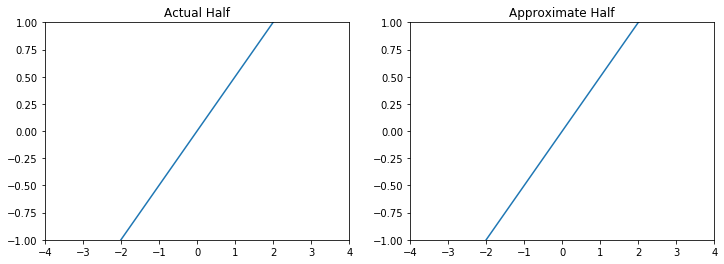

N=9,	 D=11,	 Depth=1:	 Error=   0.000000000000,	 Time=27.45955276


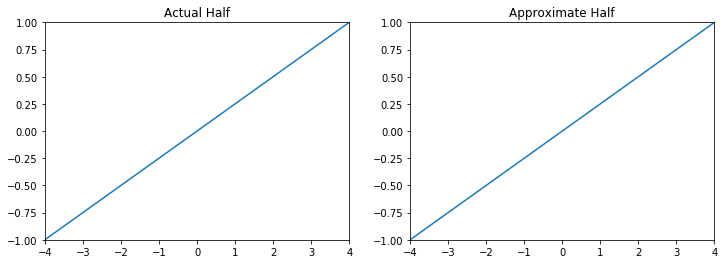

N=9,	 D=11,	 Depth=2:	 Error=   0.000000000000,	 Time=27.11537766


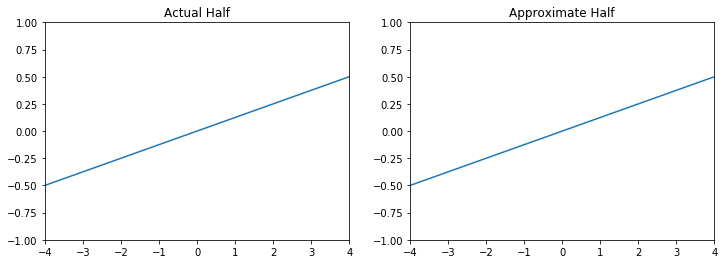

N=9,	 D=11,	 Depth=3:	 Error=   0.000000000000,	 Time=27.13725376


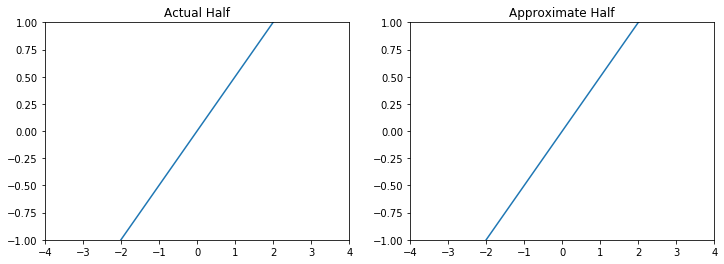

N=11,	 D=5,	 Depth=1:	 Error=   0.000000000000,	 Time=0.35867643


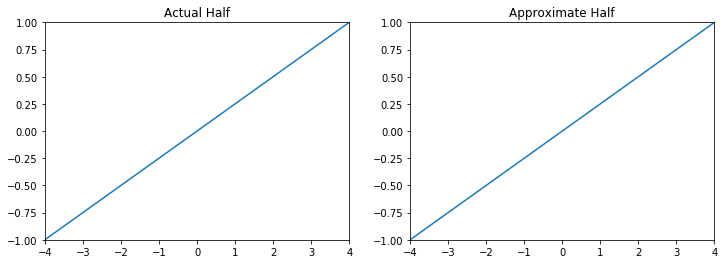

N=11,	 D=5,	 Depth=2:	 Error=   0.000000000000,	 Time=0.35840654


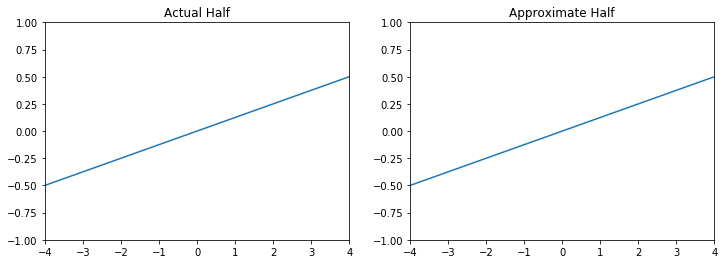

N=11,	 D=5,	 Depth=3:	 Error=   0.000000000000,	 Time=0.37275028


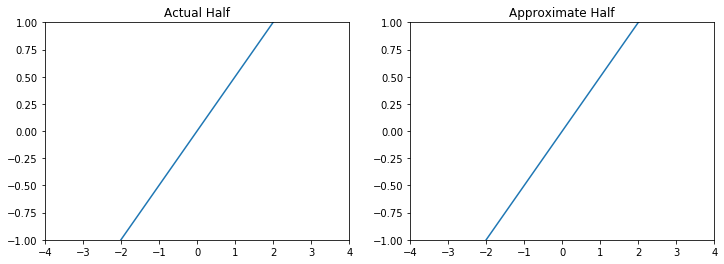

N=11,	 D=7,	 Depth=1:	 Error=   0.000000000000,	 Time=3.38387251


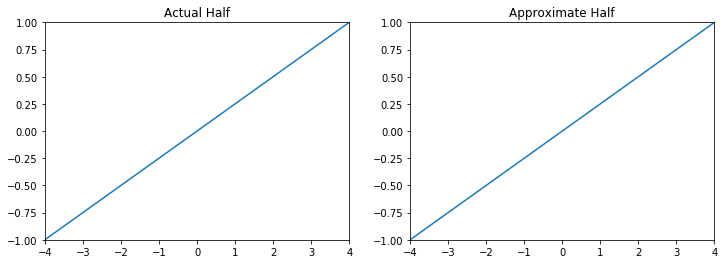

N=11,	 D=7,	 Depth=2:	 Error=   0.000000000000,	 Time=3.38915253


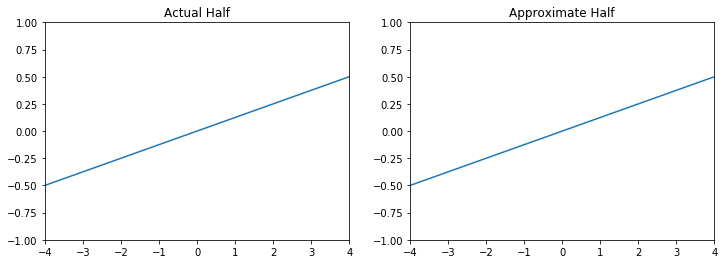

N=11,	 D=7,	 Depth=3:	 Error=   0.000000000000,	 Time=3.31240988


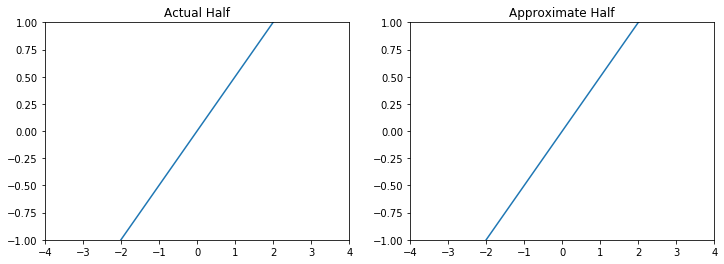

N=11,	 D=9,	 Depth=1:	 Error=   0.000000000000,	 Time=23.14417696


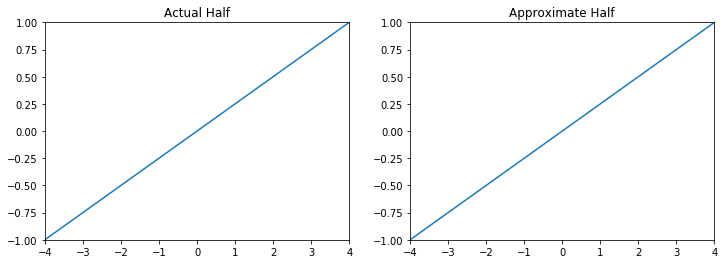

N=11,	 D=9,	 Depth=2:	 Error=   0.000000000000,	 Time=23.01426053


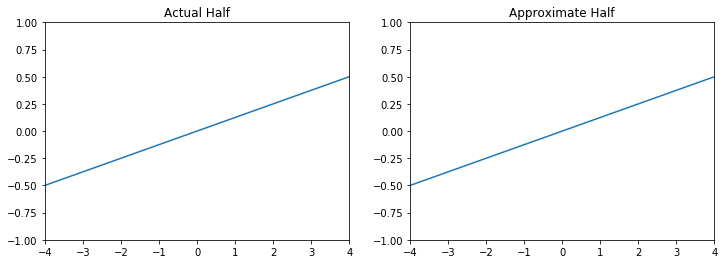

N=11,	 D=9,	 Depth=3:	 Error=   0.000000000000,	 Time=23.38693047


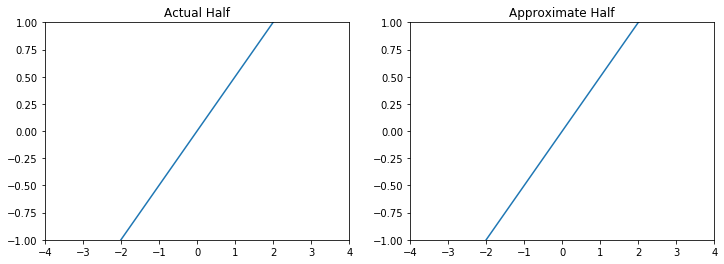

N=11,	 D=11,	 Depth=1:	 Error=   0.000000000000,	 Time=121.32085681


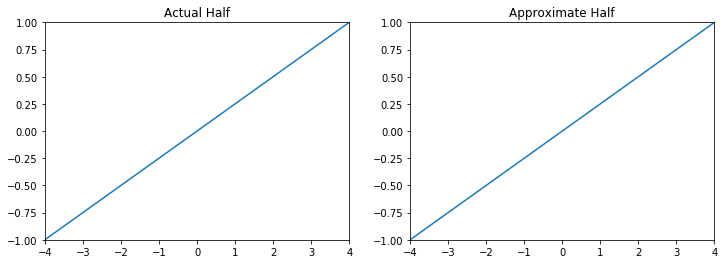

N=11,	 D=11,	 Depth=2:	 Error=   0.000000000000,	 Time=117.14060044


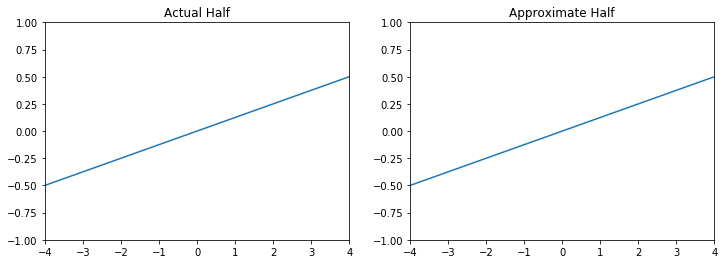

N=11,	 D=11,	 Depth=3:	 Error=   0.000000000000,	 Time=118.81660175


In [49]:
x, dx = np.linspace(-4.0, 4.0, num=8192, retstep=True)

func_degrees = [1, 3, 5, 9, 11]
var_degrees = [5, 7, 9, 11]
depths = [1, 2, 3]

runtimes = []

for fn, gfn, name in functions:
    print(f"{'-'*8}{name}{'-'*8}")
    for func_d in func_degrees:
        # Create Maclaurin series coefficients.
        s = np.array(list(gfn(func_d)))
        
        for var_d in var_degrees:
            # Intialize approximation.
            y = x
            b = np.zeros(var_d + 1)
            b[1] = 1.0

            for depth in depths:
                # Calculate actual function approximation.
                y = fn(y)

                # Perform the transformation.
                c = np.zeros_like(b)
                start = time.time()
                for i in range(var_d + 1):
                    c[i] = solve_icoeff(s, b, i)
                end = time.time()
                b = c
                elapsed = end - start

                # Get the power series estimation.
                z = np.zeros_like(x)
                for i in range(var_d + 1):
                    z = z + (b[i] * np.power(x, i))

                fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
                    
                axes[0].plot(x, y)
                axes[0].set_xlim(-4.0, 4.0)
                axes[0].set_ylim(-1.0, 1.0)
                axes[0].set_title(f"Actual {name}")

                axes[1].plot(x, z)
                axes[1].set_xlim(-4.0, 4.0)
                axes[1].set_ylim(-1.0, 1.0)
                axes[1].set_title(f"Approximate {name}")
                
                plt.show()
                    
                # Find the error in the approximation.
                error = np.sqrt(dx * np.sum(np.power(y - z, 2.0)))

                print(f"N={func_d},\t D={var_d},\t Depth={depth}:\t Error={error:17.12f},\t Time={elapsed:.8f}")
            